## Equações de movimento:

$$ \frac{dp}{dt}(t) = p(t) \times I^{-1}(t) \left( p(t) - L_0(t) \right) $$
 $$ \omega = I^{-1} \left( p - L_0 \right) $$

E dado $\omega \in \mathbb{R}^3$ podemos achar uma rotação $q$ tal que:

$$ \frac{dq}{dt} = \frac{1}{2} q \omega $$


### Importando bibliotecas

In [1]:
# Libraries for Scientific Computing
import numpy as np
import pyquaternion as pyQ

# Libraries for graphics
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d.art3d import juggle_axes

import scipy.integrate

In [2]:
def mechanics(r_0, r, masses, q_0, p_0, t, tmax, n, body_lines, name = 'CubeQ'):    
    
    ## Identity Rotation
    q_0 = [q for q in q_0]
    positions = np.empty([len(masses), 3, n])
    
    ### Physics
    
    
    ##### Inertial Tensor
    ### Input:  r -> positions;
    ###         masses -> masses from the body;
    ### Output: I -> Matrix representing the Inertial Tensor
    ##### Gil Miranda - last revision 15/09/2019

    def getInertialTensor(r, masses):
        I = np.zeros((3,3))
        for i in range(len(masses)):
            I[0][0] += masses[i]*(r[i][1]**2 + r[i][2]**2)
            I[1][1] += masses[i]*(r[i][0]**2 + r[i][2]**2)
            I[2][2] += masses[i]*(r[i][0]**2 + r[i][1]**2)

            I[0][1] -= masses[i]*(r[i][0])*(r[i][1])
            I[0][2] -= masses[i]*(r[i][0])*(r[i][2])
            I[1][2] -= masses[i]*(r[i][1])*(r[i][2])
        I[1][0] = I[0][1]
        I[2][0] = I[0][2]
        I[2][1] = I[1][2]

        return I

    ## ----------------------Rever este-----------------------------------------

    ##### Internal Angular Momentum
    ### Input:  Q -> ?;
    ###         v -> ?;
    ###         masses -> masses from the body;
    ### Output: s -> ?
    ##### Gil Miranda - last revision 15/09/2019

    def getInternalAngularMomentum(Q, v, masses):
        s = np.zeros(3)
        for (i,m) in enumerate(masses):
            s = s + m*np.cross(Q[i], v[i])
        return s
    
    ##### Center of Mass
    ### Input:  r -> position vector;
    ###         masses -> masses from the body;
    ### Output: cm -> vector for center of mass of the system
    ##### Gil Miranda - last revision 15/09/2019
    def CM(r, masses):
        cm = np.zeros(3)
        for i in range(len(r)):
            cm[0] += masses[i] * r[i][0]
            cm[1] += masses[i] * r[i][1]
            cm[2] += masses[i] * r[i][2]
        total_m = sum(masses)
        cm *= (1/total_m)
        return cm

    def translation_CM():
        r_cm = CM(r_0, masses)
        for i in range(len(r_0)):
            r_0[i] -= r_cm
            
    def particles(t, r):
        a = np.zeros([len(masses), 3])
        for i in range(len(masses)):
            a[i] = r[i](t)
        return a

    def eqOfMotion(x, t):
        # q -> quaternion for rotation
        # p -> body angular momentum
        q = pyQ.Quaternion(x[:4])
        p = x[4:]
        # Position
        pos = particles(t, r)

        #Velocities
        ep = 1e-7
        v = (particles(t+ep, r) - particles(t-ep, r))/(2*ep)

        # Tensor of Inertia
        I = getInertialTensor(pos, masses)
        Iinv = np.linalg.inv(I)

        # Angular Momentum
        L = getInternalAngularMomentum(pos, v, masses)
        dumb = np.dot(Iinv, (p-L))
        dp_dt = np.cross(p,dumb)

        omega_i = np.dot(Iinv, (p-L))
        omega = pyQ.Quaternion(0, omega_i[0], omega_i[1], omega_i[2])
    #     omega = np.concatenate(([0.], omega))
        dq_dt = 0.5 * q * omega
        return [dq_dt[0],dq_dt[1],dq_dt[2],dq_dt[3]] + [dp_dt[0], dp_dt[1], dp_dt[2]]

    def solve_eq(q_0, p_0, t):
        args = (getInertialTensor,getInternalAngularMomentum)
        q = scipy.integrate.odeint(eqOfMotion,q_0+p_0,t)
        q = np.transpose(q)
        q = q[:4,:]
        return q
    
    def set_positions(q, n, tmax):
        for k, rot in enumerate(np.transpose(q)):
            t = k*tmax/n
            p = particles(t, r)
            for i in range(0, len(masses)):
                q = pyQ.Quaternion(rot)
                positions[i, : ,k] = q.rotate(p[i, :])
    
    translation_CM()
    q = solve_eq(q_0, p_0, t)
    set_positions(q, n, tmax)
    
    ## Graphics
    
    def update_plot(num, positions, body_lines, ani_lines, sc):
        t = tmax*num/num_times
        for line, (sp, ep) in zip(ani_lines, body_lines):
            line._verts3d = positions[[sp,ep], :, num].T.tolist()
        sc._offsets3d = juggle_axes(positions[:,0, num], positions[:,1, num], positions[:,2, num], 'z')
        return sc


    #Create figure object and set animation
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_xlim3d([-1.0, 1.0])
    ax.set_ylim3d([-1.0, 1.0])
    ax.set_zlim3d([-1.0, 1.0])
    #ax.grid()


    # Lines between parts of cat

    ani_lines = [ax.plot([], [], [], 'k-')[0] for _ in body_lines]


    sc = ax.scatter3D(positions[:,0, 0], positions[:,1, 0], positions[:,2, 0], marker='o', c='red', s = 60)
    #for sp, ep in body_lines:
    #    ax.plot(positions[sp:ep, 0, 0], positions[sp:ep, 1, 0], positions[sp:ep, 2, 0])


    ani = FuncAnimation(fig, update_plot,  frames=len(time), interval=2,
            fargs=(positions, body_lines, ani_lines, sc), repeat=True)
    plt.show()
    ani.save('./'+ name + '.gif', writer='pillow', fps=15)

In [7]:
masses = np.array([3, 2, 1, 1, 0.2, 2, 1, 1, 1.3])*50

r_0 = [None]*len(masses)

r_0[0] = [0, 0, 0] #centro do corpo

r_0[1] = [0, -1, 0] #parte de trás 
r_0[2] = [0.5,  -1, 1] #pata tras 1 
r_0[3] = [-0.5, -1, 1] # pata trás 2
r_0[4] = [0, -1.5, -0.5] #cauda
 
r_0[5] = [0,  1, 0]  #parte da frente
r_0[6] = [0.5, 1, 1] #pata frente 1 
r_0[7] = [-0.5, 1,1] #pata frente 2
r_0[8] = [0, 1.2, -0.2] #cabeça

r_0 = np.array(r_0)


#Lines between each part of the body
#Only used in animation
body_lines = [
    (0, 1),
    (1, 2),
    (1, 3),
    (1, 4),

    (0, 5),
    (5, 6),
    (5, 7),
    (5, 8),
]

## Identity Rotation
q_0 = pyQ.Quaternion(axis = [1,0,0], radians = 0)
p_0 = [0,0,0]

tmax = 10
num_times = 400
time = np.linspace(0,tmax,num_times)
r = [0 for i in range(0, len(masses))]

## wth is going on here?
for i in range(0,len(masses)):
    r[i] = lambda t, i=i: r_0[i, :]

    
tmax_r1 = tmax/20
ang_max = -np.pi/6
freq = 2*np.pi/(tmax - tmax_r1)
for i in (1,2,3,4):
    def ri(t, j=i):
        if t < tmax_r1:
            t_q = pyQ.Quaternion(axis = [1,0,0], radians = t*ang_max/tmax_r1)
            return t_q.rotate(r_0[j, :])
        else:
            t_q = pyQ.Quaternion(axis = [1,0,0], radians = ang_max)
            rx = t_q.rotate(r_0[j, :])
            axis = t_q.rotate(r_0[1, :]) - t_q.rotate(r_0[0, :])
            t_q2 = pyQ.Quaternion(axis = axis, radians = freq*(t-tmax_r1))
            
            return t_q2.rotate(rx)
    r[i] = ri

for i in (5,6,7,8):
    def ri(t, j=i):
        if t < tmax_r1:
            t_q = pyQ.Quaternion(axis = [1,0,0], radians = -t*ang_max/tmax_r1)
            return t_q.rotate(r_0[j, :])
        else:
            t_q = pyQ.Quaternion(axis = [1,0,0], radians = -ang_max)
            rx = t_q.rotate(r_0[j, :])
            axis = t_q.rotate(r_0[1, :]) - t_q.rotate(r_0[0, :])
            t_q2 = pyQ.Quaternion(axis = axis, radians = -freq*(t-tmax_r1))
            
            return t_q2.rotate(rx)
    r[i] = ri    

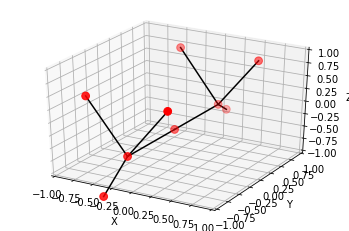

In [8]:
mechanics(r_0, r, masses, q_0, p_0, time, tmax, num_times, body_lines, name = 'falling_cat')